# MLAAPDE Demo
created: 2021-11-11  
updated: 2022-02-03  
author: Hank Cole
***
## WARNING
- **DO NOT ATTEMPT TO RUN THIS WHOLE NOTEBOOK!**
  - It technically should execute fine, but it may overwrite your working data.
  - And it would take a very long time to complete.

***
## Summary

For ~~more~~ less information, please reference the [MLAAPE GitLab repo](https://code.usgs.gov/ghsc/neic/neic-mlaapde)

This jupyter notebook describes MLAAPDE's dataset generation, validation, and access methods. It demonstrates usage of the classes contained in the mlaapde python module and illustrates some population statistics for the dataset. Additionally some key parts of the code are duplicated here so that users are aware of how certain values in the labelling data are generated.

The MLAAPDE python package contains three main modules: builder, validate, and access. 

The 'builder' module downloads [PDE QuakeML files from USGS ScienceBase](https://www.sciencebase.gov/catalog/item/5d10ce07e4b0941bde550110) using [sciencebasepy](https://github.com/usgs/sciencebasepy). The QuakeML files are flattened into potential catalog entries that are used to query for waveforms with the [FDSN/IRIS obspy client](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

The 'validate' module simply checks that all label catalog CSVs and waveform archive HDF5s are readable, that every entry in the catalog has a corresponding waveform, and generates a search index file that is required by the access methods. The 'access' module contains a class that provides access methods to sample the dataset to return waveforms and label data in array format ready to be used for ML input.  

The earliest data MLAAPDE can collect is from July of 2013 when the PDE begins. The latest MLAAPDE data hosted on ScienceBase is though 2020. Updates to the hosted data will be posted when the PDE for that year is reviewed. However, the MLAAPDE builder module can be used to generate data from the most up-to-date PDE entries available on ScienceBase.

***
## Notes
- It is recommended to use this demo as a cookbook.
- The terms "catalog" and "archive" specifically refer to the contents of csv and hdf5 files respectively. 
  - The catalog contains all label data and phase metadata.
  - The archive contains all waveform data with minimal metadata.
- You may find it advantageous to use mlaapde through a [remote Jupyer Notebook](https://docs.anaconda.com/anaconda/user-guide/tasks/remote-jupyter-notebook/).
- Not all exceptions that could be generated by mlaapde methods are caught gracefully.
  - Normal use, following the documentation should not result in any exception.
  - Some exceptions are handled and the code is written in a way that input should be relatively easy to debug.
  - Unfortunately, due to the complexity of sanatizing all input, this responsibility is on the user.
  - However, experience debugging python and williness to dig refer to source code will help.

# Setup

Using MLAAPDE will require the following:
- **At least 600GB of available disk space** (for 2013-2020 and [P,Pn,Pg],[S,Sn,Sg] config).
- A relatively high-performace computer (servers with large RAM capacity are recommended).
  - Large queries with access methods will be limited by RAM.
- A local installation of Anaconda to handle required python packages.
- User familiarity with Python and the HDF5 file format.
- At least some degree of individual patience.

Please see the README.md file included in the repo and on the GitLab page for steps to download and "install" MLAAPDE and to prep your environment to use it.


In [2]:
#navigate to the 'neic-mlaapde' dir
!cd ~/neic-mlaapde/

In [3]:
#you can view the explicit python dependencies for mlaapde in the .yaml file
!cat mlaapde.yaml

name: mlaapde
channels:
  - defaults
  - conda-forge
dependencies:
  - tensorflow
  - h5py
  - python=3.7
  - numpy
  - matplotlib
  - pandas
  - jupyterlab
  - jupyterthemes
  - obspy
  - requests


## Create the Conda Environment

Create the mlaapde environment with the following command:  
`conda create -f mlaapde.yaml`  

Then activate it:  
`conda activate mlaapde`  

One additional dependency ([sciencebasepy](https://github.com/usgs/sciencebasepy)) not included in the yaml is required:  
`pip install sciencebasepy` 

Note that the mlaapde environment also includes tensorflow. This is because there are version compatability issues between python, tensorflow, obspy, and sciencebasepy that could make building the environment on your own tricky. Since you are likely to use tensorflow with mlaapde, it has been included for that convenience. However, tensorflow is not used anywhere in the mlaapde package.

## Config File

When mlaapde is run for the first time, it will generate an .ini file that serves as static configuration.

It should contain something like the following:

[DEFAULT]<br>
data_dir = home/user/neic-mlaapde/data<br>
logs_dir = home/user/neic-mlaapde/logs<br>
iris_n_attempt = 6<br>
iris_sleep_sec = 2<br>
iris_timeout_sec = 12<br>
pre_event_sec = 60<br>
post_event_sec = 60<br>
resample_hz = 40<br>
valid_phases = [P,Pn,Pg];[S,Sn,Sg]<br>
<br>
The data_dir and logs_dir parameters must be modified before using mlaapde. If using a remote server with the mlaapde repo located in your home directory, you may need to point these to a higher level directory if you have a limit on the size of your home directory.  

The parameters with the iris prefix relate to how patient mlaapde should be when waiting for interruptions in internet connection when downloading waveform data. The default parameters will handle nearly all ephermeral connectivity issues, but an extended downtime in connection will result in gaps in the data.  

The pre and post event second parameters define how much waveform data is requested relative to the arrival time for a given phase. If IRIS returns waveform data with any gaps in the expected trace length, that data will not be added to the waveform archive.

In [7]:
#you can view the current config file if it exists
!cat mlaapde/mlaapde.ini

[DEFAULT]
data_dir = /home/sdybing/neic-mlaapde/mlaapde/data
logs_dir = /home/sdybing/neic-mlaapde/mlaapde/logs
iris_n_attempt = 6
iris_sleep_sec = 2
iris_timeout_sec = 12
pre_event_sec = 60
post_event_sec = 60
resample_hz = 40
valid_phases = [P,Pn,Pg];[S,Sn,Sg]



## Check Setup

If you have a valid environment and config file you should be able to import mlaapde.

In [5]:
#first you may need to append the neic-mlaapde dir to your path if your cursor isnt there.
import sys
sys.path.append('~/neic-mlaapde')

In [6]:
# If you have not run mlaapde before you can generate the .ini file by importing mlaapde
# This will execute silently if you already have an .ini file
import mlaapde

#we can also check the current version of mlaapde if it was imported above
mlaapde.__version__


Config file not found!

A default config file has been generated:
  path=/home/sdybing/neic-mlaapde/mlaapde/mlaapde.ini
Please check the config file and try again.



'1.0.7'

In [8]:
#note: the mlaapde package and all modules contain the UTC method
#this is just a convenient abbreviation of the obspy.UTCDateTime method
from mlaapde import UTC
print(f'current time is {UTC().isoformat()}')

current time is 2022-06-24T17:08:57.477922


# Generating the Dataset
***

A version of the MLAAPDE dataset is available for download from the USGS's ScienceBase website. However, the dataset can also be generated locally using the Python module. This may be necessary if the user would like to change certain parameters of the dataset or only acquire a certain portion of it.  

The version of MLAAPDE hosted on ScienceBase is generated with the following parameters that are also the default values when generating the dataset locally:
- Resample frequency = 40 Hz
- Pre-Event seconds = 60 s
- Post-Event seconds = 60 s
- Valid Phases: [P,Pn,Pg];[S,Sn,Sg]

Note the special formatting for valid phases. Valid phases are parsed as individual phases and/or groups of phases enclosed in brackets. Phases and phase groups need to be separated by a semicolon, while phases within groups need to be separated by commas. During parsing, if valid phases are configured to contain groups, only the earliest phase within a group is considered. Any phase listed in the QuakeML phase hints will work (even ones like PKiKP).

Some examples:
- 'P' - Only P phases are considered
- 'P;S' - Only P and S phases are considered, both can be included
- '[P,Pn,Pg]' - Only P, Pn, and Pg phases are considered, but only the earliest arriving phase
- '[P,Pn,Pg];[S,Sn,Sg]' Only the earliest P and S phase groups are considered, max of 2 phases per event-station

Be aware that modifying these parameters will substantially affect the size of the dataset. If you are planning to modify the parameters to increase the resampling frequency or include a larger time window, estimate the impact on the overall disk use and monitor it while the mlaapde builder runs.  

Generating the dataset will create the following directories in the `data_dir`:
- `sciencebase_pde` - contains all of the QuakeML files downloaded from ScienceBase.
- `flat_pde` - contains all of the flattened QuakeML files (these are "potential" picks).
- `mlaapde` - contains all of the catalogs and archives parsed into the year-week deisgnation from the PDE.

When the dataset generation is complete (and aggregation is done) the entire dataset will be located in `data_dir`. The subdirectories list above can then be removed if they weren't already removed by cleanup methods.

***
### IMPORTANT NOTES:
- **Generating the entire dataset locally will take a very long time to complete, likely several days.**  
- It is recommended to test the builder workflow for the 2nd half of 2013, then proceed to the rest.
- When generated at the NEIC, multiple instances of mlaapde.builder were started for pseudo-concurrency.
- Consider using a multiplexer like [screen](https://www.gnu.org/software/screen/manual/screen.html) or [tmux](https://man7.org/linux/man-pages/man1/tmux.1.html) so that you can more easily leave multiple instances running.
- It is best to run the build methods from a script or in ipython, and not from a Jupyter Notebook or IDE
- You can monitor the progress of the build methods with commands like:
  - `tail -f /path/to/logs_dir/mlaapde.log`  -  shows a live feed of the log
  - `tail -5 | grep "INFO - 2013"`  -  shows the most recent progress of the year 2013
  - `ls -lah /path/to/data_dir/mlaapde`  -  just look at what files have been populated

## Schema

A dataset generated with MLAAPDE has two main components; the csv phase catalogs and the hdf5 waveform archives. The csv catalog contains a flattened table of phase arrival information along with the related event, source, and path label data. Each entry in the csv catalogs is keyed by a unique 'phase_id' that is an extension of 'event_id' and 'waves_id' that link events and event-stations respectively. The waveform archives contain 3-component waveforms sorted into tiered groups by event_id, wave_id, and phase_id. A small amount of metadata storing builder configuration stats are also included in the hdf5 file attributes. The combination of these two schemas makes it easy to access a MLAAPDE dataset with custom software if desired, but most users will find it more convenient to use the MLAAPDE module to do so.

## Constructor

In [8]:
#import the builder class from module
from mlaapde.builder import MLAAPDE_Builder

#the default constructor will read data_dir from the prop file
# mlpb = MLAAPDE_Builder()

#However, if you are testing your workflow, you might want to temporarily point data_dir elsewhere
mlpb = MLAAPDE_Builder(name='demo', data_dir='demo_data')

#If you are using the constructor just to generate a single year, it is wise to name it so.
# mlpb = MLAAPDE_Builder(name='2013')

2022-01-17 17:11:23 - mlaapde.builder.demo - INFO - demo.__init__() starting
2022-01-17 17:11:23 - mlaapde.builder.demo - INFO - demo.__init__() complete


## Generation Steps

In [2]:
#download and unzip all PDE files.
#this step runs reasonably fast (<1hr)
mlpb.download_pde()
mlpb.unzip_pde()

2021-11-12 11:29:47,159 - mlaapde.builder.demo - INFO - demo.download_pde() starting
2021-11-12 11:31:10,906 - mlaapde.builder.demo - INFO -   downloading PDE for year=2013
2021-11-12 11:32:55,734 - mlaapde.builder.demo - INFO -   downloading PDE for year=2014
2021-11-12 11:37:16,527 - mlaapde.builder.demo - INFO -   downloading PDE for year=2015
2021-11-12 11:43:58,255 - mlaapde.builder.demo - INFO -   downloading PDE for year=2016
2021-11-12 11:48:37,477 - mlaapde.builder.demo - INFO -   downloading PDE for year=2017
2021-11-12 11:52:22,040 - mlaapde.builder.demo - INFO -   downloading PDE for year=2018
2021-11-12 11:57:34,867 - mlaapde.builder.demo - INFO -   downloading PDE for year=2019
2021-11-12 12:02:12,670 - mlaapde.builder.demo - INFO -   downloading PDE for year=2020
2021-11-12 12:06:44,318 - mlaapde.builder.demo - INFO -   downloading PDE for year=2021
2021-11-12 12:10:09,500 - mlaapde.builder.demo - INFO - demo.download_pde() complete. took 40.37 min
2021-11-12 12:10:09,51

In [ ]:
#generate intermediate mlaapde data for a year

#this step takes a very long time (>1day) so be patient

#It will take less time if you start with 2013, which only has data from July-December
year=2013

#takes year and week-number arguments, matching the PDE structure
#You can use week 53 for any year to safely ensure the entire end-of-year is considered
mlpb.flatten_pde_range(year,1,year,53) #flattens qml to csv files of relevant data
mlpb.waveform_range(year,1,year,53) #performs waveform/inventory queries from IRIS

In [ ]:
#aggregate intermediate products

#aggregation is a required step to use the access methods with the default constructor
#  this is because it load from an intermediate directory then exports the aggregated files to `data_dir`
#  without this step, access methods need to point to the intermediate directory `data_dir/mlaapde/`

#option 1: montly aggregation (used for hosted dataset)
start = UTC('2013-7-1') #inclusive (will include an event AT that timestamp)
end = UTC('2014-1-1') #exclusive (will exclude an event AT that timestamp)
mlpa.aggregate_monthly(start,end)

#option 2: custom range (useful for specific problems)
# start = UTC('2018-11-10')
# end = UTC('2019-06-21')
# mlpb.aggregate_range(start,end)

In [10]:
#During dataset generation there are steps where a potential phase can be dropped.
#This is only done if the potential phase would not result in a valid dataset entry.
#The phase_id of dropped phases is retained along with a reason for why it was dropped.
#This information is stored in the following attributes:

#Missed QML happens when loading a QML file into an obspy.catalog throws an exception
#The three possible reasons are: ValueError, TypeError, IndexError
mlpb.missed_qml_list
mlpb.missed_qml_reason

#Missed flatten event happens when an event doesn't contain a valid source magnitude, magnitude_type, or magnitude_author
mlpb.missed_flatten_event_list
mlpb.missed_flatten_event_reason

#Missed flatten phase happens when a phase is missing a p_pick or inventory metadata.
mlpb.missed_flatten_wave_list
mlpb.missed_flatten_wave_reason

#missed wave phase happens when there are issues with the waveform returned by IRIS.
#This can happen during the query from: FDSNNoDataException, FDSNException, IncompleteRead.
#It can also happen during QC from: NoWave, ZeroDivisionError during resample and detrend.
#It also happens when IRIS returns a waveform with less or more than 3 channels, or with data containing gaps
mlpb.missed_wave_phase_list
mlpb.missed_wave_phase_reason

#to retain the missing phase data, you can use the included pickle method
#this will save the object in data_dir/pickles with the object name and a timestamp of its creation as the filename.
mlpb.pickle('demo pickle')

#note: for these attributes to be populated, the dataset has to be generated with the mlpb object.
#note: most missed events are dropped out of necessity, not choice, because otherwise the program would except and fail
#note: overall missed phases are quite rare, tho eventually it may be worth writing workarounds to add the missed phases

2022-01-17 17:13:13 - mlaapde.builder.demo - INFO - saved pickle file, demo1642464793610032896.pickle


## Generation Nuance

Gathering the PDE data for input relies on the following:
- Parent ID is hardwired to: 5d10ce07e4b0941bde550110
- Expects the child items to be each PDE year  

Flattened data uses prefered origin and focal mechanism listed in the QML.  

Only US authored event_ids are present.

Source-station azimuth, back azimuth, and distances are dervied using the obspy.geodetics package.

Steps to query and detrend waveforms:
- Get waveform stream with obspy.iris_client.get_waveforms()
  - gets waveform with 1 buffer second on beginning and end to trim edge effects
- resamples stream with obspy.stream.resample()
- detrends with obspy.stream.detrend('demean')
- detrends with obspy.stream.detrend('linear')
- stream is trimmed to time window defined in ini file

Signal-to-noise ratio is computed with the following lines:  
`noise = wave[:,0:(self.pre_event_sec-1)*self.resample_hz]
idxp = self.pre_event_sec*self.resample_hz
signal = wave[:,idxp:idxp+int(self.post_event_sec/2)*self.resample_hz]
noise_rms = np.sqrt(np.mean(noise**2))
signal_rms = np.sqrt(np.mean(signal**2))
snr = signal_rms/noise_rms
snr_db = 20*np.log(snr)`

# Validating the Dataset
***

Whether you download the dataset from ScienceBase or generate it locally, you will need to validate it before using the access methods. This is because the validation builds a filename search index that is used by the access methods to lookup entries given a phase or event id. It also ensures that there are no spooky problems with the catalogs or archives.  

If you modify the contents of mlaapde's data_dir or point data_dir to a new location you need to revalidate the dataset to ensure the search index is up-to-date.

Technically you can just build the index and don't need to validate it, but this is not recommended.

Look for this line in the console or log output to ensure that validation is sucessful:  
`INFO - All phases listed in index exist in archives`

In [1]:
from mlaapde.validate import MLAAPDE_Validate
mlpv = MLAAPDE_Validate() #can also take name and data_dir arguments, otherwise defaults to ini file parameters
mlpv.validate_search_index(mlpv.build_search_index())

2021-11-11 12:44:21,169 - mlaapde.access.MLAAPDE_Validate - INFO - MLAAPDE_Validate.__init__() starting
2021-11-11 12:44:21,171 - mlaapde.access.MLAAPDE_Validate - INFO - MLAAPDE_Validate.__init__() complete
2021-11-11 12:44:21,173 - mlaapde.access.MLAAPDE_Validate - INFO - MLAAPDE_Validate.build_index() starting
2021-11-11 12:44:28,665 - mlaapde.access.MLAAPDE_Validate - INFO - MLAAPDE_Validate.build_index() complete. took 0.12 min.
2021-11-11 12:44:28,722 - mlaapde.access.MLAAPDE_Validate - INFO - MLAAPDE_Validate.validate_index() starting
2021-11-11 12:44:28,801 - mlaapde.access.MLAAPDE_Validate - INFO -   working on /Users/hcole/neic-mlaapde/data/201307_mlaapde.h5
2021-11-11 12:44:32,695 - mlaapde.access.MLAAPDE_Validate - INFO -   working on /Users/hcole/neic-mlaapde/data/201308_mlaapde.h5
2021-11-11 12:44:46,977 - mlaapde.access.MLAAPDE_Validate - INFO -   working on /Users/hcole/neic-mlaapde/data/201309_mlaapde.h5
2021-11-11 12:45:02,682 - mlaapde.access.MLAAPDE_Validate - INFO 

In [ ]:
#if you already have a search_index, but want to validate it you can run this instead
mlpv.validate_search_index(mlpv.load_search_index)

# Accessing the Dataset

The MLAAPDE_Access class handles querying and filtering of the dataset. It offers three levels of sampling that give the user more granular control if desired. At the highest level, the `get_data()` method will automatically query, filter, sample, and load waveforms and labels then return them split into training, validation, and (optionally) testing partitions. For more fine control of the query, a combination of `sample_catalog()` and `read_archive()` can be used to collect phases and retrieve their waveforms after performing custom filtering of the catalog. For even more fine control, the private methods can be called to simply retrieve portions of the catalog or archive.  



In [1]:
#load the module
from mlaapde.access import MLAAPDE_Access

## Constructor

In [2]:
#the default constructor is usually appropriate
mlpa = MLAAPDE_Access()

#you can pass a custom data_dir into the constructor if you have multiple versions of the dataset
# mlpa = MLAAPDE_Access(data_dir='/path/to/mlaapde_100hz')

#you can name the access object if desired
#  could be useful if you are trying to hold multiple queries in memory at the same time
# mlpa100 = MLAAPDE_Access(name='100hz_queries', data_dir='/path/to/mlaapde_100hz')
# mlpa40  = MLAAPDE_Access(name='40hz_queries')

2022-02-03 08:11:57 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() starting
2022-02-03 08:12:11 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() complete


## Queries

All of the access methods will execute without any arguments, using hardwired default values. Any filtering keyword argument can be applied at high or low level, being ignored if not relevant to the current method and propagating to lower-level methods if relevant. If you are writing your own application and plan to use MLAAPDE_Access, you can pass the keyword arguments to its methods from your applications as a `**kwargs` object, but be aware that you will need to have any other mlaapde-relevant keyword arguments bundled into that object.


***
The default values used for filtering the catalog can be displayed by calling the attribute:  
`mlpa.default_args`

***
A list of the available labels can be returned by calling the method:  
`mlpa.available_labels()`  

In [3]:
mlpa.default_args

{'nsamp': 10000,
 'split': [0.8, 0.2],
 'labels': ['phase_id',
  'phase_time',
  'phase_travel_sec',
  'source_distance_deg',
  'source_back_azimuth_deg'],
 'valid_phases': [['P', 'Pn', 'Pg'], ['S', 'Sn', 'Sg']],
 'only_oriented': True,
 'min_snr_db': 10,
 'max_snr_db': False,
 't1': False,
 't2': False,
 'bpf_freq_min': 0.01,
 'bpf_freq_max': 10.0,
 'trim_pre_sec': False,
 'trim_post_sec': False,
 'normalize': 'stream',
 'rotate': False}

In [4]:
mlpa.available_labels()

['phase_id',
 'waves_id',
 'event_id',
 'nscl_code',
 'network',
 'station',
 'channel',
 'location',
 'station_latitude',
 'station_longitude',
 'station_elevation_m',
 'chan_order_3c',
 'chan_azimuth_1',
 'chan_azimuth_2',
 'chan_azimuth_Z',
 'source_type',
 'source_origin_time',
 'source_latitude',
 'source_longitude',
 'source_depth_km',
 'source_magnitude',
 'source_magnitude_type',
 'source_magnitude_author',
 'focal_author',
 'focal_np1_strike',
 'focal_np1_dip',
 'focal_np1_rake',
 'focal_np2_strike',
 'focal_np2_dip',
 'focal_np2_rake',
 'moment_Mrr',
 'moment_Mtt',
 'moment_Mpp',
 'moment_Mrt',
 'moment_Mrp',
 'moment_Mtp',
 'moment_scalar_moment',
 'stf_type',
 'stf_duration_sec',
 'stf_rise_sec',
 'stf_decay_sec',
 'phase_time',
 'phase_hint',
 'phase_author',
 'phase_status',
 'phase_arrival_time_weight',
 'phase_arrival_time_residual',
 'phase_travel_sec',
 'phase_analyst_id',
 'source_distance_deg',
 'source_distance_km',
 'source_azimuth_deg',
 'source_back_azimuth_deg'

### Low-level Queries

In [5]:
#sample_catalog() will return a dictionary containing lists of phase_ids and a pandas.Dataframe with all of the labels
#This method is useful if you want to examine all of the labels for a sampling

#sampling works by loading all of the catalogs into a pandas.Dataframe,
#  then filtering it to the default or user arguments,
#  then making a random sampling of the phase entries using np.random.choice().
#The sampled phase_ids are then split into training/validation/testing sets
#  and the catalog Dataframe is trimmed to only include the associated phases.

#Because catalog filtering is done before random sampling, this method can be slow even when nsamp is low

samples, catalog = mlpa.sample_catalog()

2022-02-02 16:36:28 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-02 16:53:41 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 17.2 min


In [6]:
#the valid_phases filter can be computationally expensive if sorting phase arrivals,
#  but you can improve performance by simplifying the filter...

samples, catalog = mlpa.sample_catalog(valid_phases=['P', 'Pn', 'Pg'])

#  or excluding it altogether by setting a False flag (this will return all phases)
# samples, catalog = mlpa.sample_catalog(valid_phases=False)

2022-02-02 16:53:57 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-02 16:54:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 0.9 min


In [7]:
#'samples' contains 2 or 3 lists of phase ids with the following keys
print(samples.keys())

#the phase_ids are formatted with the event_id followed by the station where the waveform is recorded in NSCL dotcode
print(samples['training'][0])

dict_keys(['training', 'validation'])
usb000ikfk_AK.BRLK.BH*.--_Pn


In [8]:
#'catalog' is contains all of the metadata for phases in all lists from 'samples'
catalog

,phase_id,waves_id,event_id,nscl_code,network,station,channel,location,station_latitude,station_longitude,...,phase_arrival_time_weight,phase_arrival_time_residual,phase_travel_sec,phase_analyst_id,source_distance_deg,source_distance_km,source_azimuth_deg,source_back_azimuth_deg,source_takeoff_deg,snr_db
4,usb000ikfk_AK.BRLK.BH*.--_Pn,usb000ikfk_AK.BRLK.BH*.--,usb000ikfk,AK.BRLK.BH*.--,AK,BRLK,BH*,--,59.751100,-150.906300,...,0.021,-2.1,34.850,2932,2.281470,253.687887,244.441062,60.903265,46.0,17.687465
391,usb000ikh7_KR.BOOM.BH*.--_P,usb000ikh7_KR.BOOM.BH*.--,usb000ikh7,KR.BOOM.BH*.--,KR,BOOM,BH*,--,42.492220,75.942220,...,0.014,-0.2,525.370,1461,48.899870,5437.417467,297.567908,73.356811,23.6,12.168699
394,usb000ikh7_KR.NRN.BH*.--_P,usb000ikh7_KR.NRN.BH*.--,usb000ikh7,KR.NRN.BH*.--,KR,NRN,BH*,--,41.422220,75.970000,...,0.014,-0.3,527.520,1461,49.194011,5470.124474,296.207387,72.482782,23.6,13.588475
1958,usb000ilce_NN.WAK.HH*.--_P,usb000ilce_NN.WAK.HH*.--,usb000ilce,NN.WAK.HH*.--,NN,WAK,HH*,--,38.504300,-119.438200,...,0.004,0.4,722.190,1464,81.848069,9101.090067,42.121222,231.955951,23.1,12.017882
1998,usb000ilce_TW.NACB.BH*.--_P,usb000ilce_TW.NACB.BH*.--,usb000ilce,TW.NACB.BH*.--,TW,NACB,BH*,--,24.173800,121.594704,...,0.009,-2.2,686.600,1461,75.818383,8430.619558,304.321497,123.648420,25.2,23.344353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095589,us6000d3kv_GR.GRA1.BH*.--_Pn,us6000d3kv_GR.GRA1.BH*.--,us6000d3kv,GR.GRA1.BH*.--,GR,GRA1,BH*,--,49.691887,11.221720,...,0.820,-0.2,80.517,3190,5.415642,602.191883,323.476881,139.808104,45.9,11.858819
5095749,us6000d3lf_OE.ARSA.BH*.--_Pn,us6000d3lf_OE.ARSA.BH*.--,us6000d3lf,OE.ARSA.BH*.--,OE,ARSA,BH*,--,47.250500,15.523200,...,1.140,0.0,32.506,3190,1.901586,211.446694,344.074676,163.520249,45.9,41.386891
5096013,us6000d3ms_OK.BLOK.HH*.--_Pg,us6000d3ms_OK.BLOK.HH*.--,us6000d3ms,OK.BLOK.HH*.--,OK,BLOK,HH*,--,36.760615,-97.215026,...,2.120,-0.0,16.971,3230,0.945785,105.166464,179.106100,359.117218,85.7,14.735736
5096020,us6000d3ms_OK.GC02.EH*.--_Pg,us6000d3ms_OK.GC02.EH*.--,us6000d3ms,OK.GC02.EH*.--,OK,GC02,EH*,--,36.851500,-97.859590,...,2.070,-0.0,17.751,3230,0.990140,110.098574,210.481181,30.101880,86.0,66.036891


In [9]:
#read_archive() will load and filter waveforms when given a list of phase_ids
#This method is useful when you have collected a custom list of phase_ids and want to load the waveforms
train_waves = mlpa.read_archive(samples['training'])

#This will query the file search index for the necessary hdf5 files for the given phase_ids,
#  then will loop over the hdf5 files and load the associated waveforms into memory
#  while preserving the original order of the phase_ids

#basic waveform filtering like bandpass filtering, normalization, or trimming is done in this method

#This method will load all of the requested waveform into RAM
#  It does NOT perform a check that you will have enough RAM to load the request
#  However, if it runs out of memory it should throw an exception gracefully and exit without crashing your machine

2022-02-02 16:54:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-02 17:04:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 10.0 min


In [10]:
#read_labels() will simply filter a given catalog pandas.Dataframe to the given phase_ids and return as a numpy.Array
#This low-level method is less likely to be situationally useful compared to sample_catalog or read_archive
# labels = mlpa.read_labels(samples['training'], catalog)

#this method should be used with the optional 'labels' keyword argument to return the desired label arrays.
labs = ['source_magnitude', 'source_magnitude_type']
labels = mlpa.read_labels(samples['training'], catalog, labels=labs)

2022-02-02 17:04:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() starting
2022-02-02 17:04:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() complete. took 0.0 min


In [11]:
#if no labels are passed to read_labels, it uses the hardwired defaults:
mlpa.default_args['labels']

['phase_id',
 'phase_time',
 'phase_travel_sec',
 'source_distance_deg',
 'source_back_azimuth_deg']

In [12]:
#the returned 'labels' object is a dictionary with keys corresponding to the requested labels.
print(labels.keys())

#and each member is a numpy.Array of the requested values, in order of the given phase_ids
labels['phase_travel_sec']

dict_keys(['phase_id', 'phase_time', 'phase_travel_sec', 'source_distance_deg', 'source_back_azimuth_deg', 'source_magnitude', 'source_magnitude_type'])


array([  34.85 ,  525.37 ,  527.52 , ...,   16.971,   17.751,  304.289])

### High-level Queries

In [13]:
#Most data queries can be completed with the high-level method get_data() that combines the low-level methods
waves, labels = mlpa.get_data()

2022-02-02 17:04:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.get_data() starting
2022-02-02 17:04:50 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-02 17:21:44 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 16.9 min
2022-02-02 17:22:00 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-02 17:32:07 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 10.1 min
2022-02-02 17:32:07 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-02 17:40:19 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 8.2 min
2022-02-02 17:40:19 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() starting
2022-02-02 17:40:19 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() complete. took 0.0 min
2022-02-02 17:40:19 - mlaapde.access.MLAAPDE

In [3]:
#many keyword arguments can be given to get_data() that propagate to the low-level methods
#additional keyword argument filtering options will be added over time.

#this will return 15 s long waveforms with snr_db>15, bandpassed 4-10 hz, with the given labels+defaults
waves, labels = mlpa.get_data( 
                              bpf_freq_min=4.0, bpf_freq_max=10.0, #uses obspy default bandpass filtering
                              trim_pre_sec=5.0, trim_post_sec=10.0, #trim to pre/post sec relative to p_arrival
                              normalize='stream', #stream/station normalization
                              labels=['snr_db', 'source_latitude', 'source_longitude'])

# waves, labels = mlpa.get_data(normalize='trace') #normalize per trace/channel

2022-02-03 08:12:11 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.get_data() starting
2022-02-03 08:12:11 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-03 08:29:15 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 17.1 min
2022-02-03 08:29:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-03 08:39:24 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 9.9 min
2022-02-03 08:39:24 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 8.1 min
2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() starting
2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_labels() complete. took 0.0 min
2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_

In [4]:
#two important optional kwargs are 'nsamp' and 'split'
#nsamp simply defines the number of samples that are chosen from the available catalog
#split defines how nsamp is divided into training, validation, and (optionally) testing sets.

waves, labels = mlpa.get_data(nsamp=100_000, split=[0.7, 0.2, 0.1], valid_phases=['P','Pn','Pg'])

#the default nsamp is 10_000
#the default split is 0.8 training and 0.2 validation with no testing set

2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.get_data() starting
2022-02-03 08:47:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-03 08:48:22 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 0.9 min
2022-02-03 08:48:22 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-03 09:30:21 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 42.0 min
2022-02-03 09:30:22 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-03 09:47:31 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 17.1 min
2022-02-03 09:47:31 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() starting
2022-02-03 09:59:52 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.read_archive() complete. took 12.3 min
2022-02-03 09:59:52 - mlaapde.access.MLAA

## Plotting

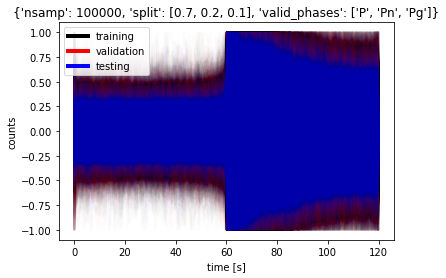

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':"{'nsamp': 100000, 'split': [0.7, 0.2, 0.1], 'valid_phases': ['P', 'Pn', 'Pg']}"}, xlabel='time [s]', ylabel='counts'>)

In [5]:
#you can view a collection of waves as a sanity check that your snr_db, trimming, and filtering look OK.
mlpa.plot_waves(waves)

# Catalog Information and Population Statistics


In [6]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot #optional to match style if using jupyterthemes
jtplot.style()

from mlaapde.access import MLAAPDE_Access
from mlaapde.util import cast_datetime_index
mlpa = MLAAPDE_Access()

2022-02-03 10:06:33 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() starting
2022-02-03 10:06:48 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() complete


In [7]:
#load the entire available catalog
_, catalog = mlpa.sample_entire_catalog()
cast_datetime_index(catalog, 'source_origin_time')

2022-02-03 10:07:21 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting
2022-02-03 10:08:18 - mlaapde.access.MLAAPDE_Access - WARNING - nsamp=False, sampling everything (n=5_101_567)
2022-02-03 10:09:08 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() complete. took 1.8 min


In [8]:
catalog

,phase_id,waves_id,event_id,nscl_code,network,station,channel,location,station_latitude,station_longitude,...,phase_arrival_time_weight,phase_arrival_time_residual,phase_travel_sec,phase_analyst_id,source_distance_deg,source_distance_km,source_azimuth_deg,source_back_azimuth_deg,source_takeoff_deg,snr_db
0,usc000irgm_GE.SNAA.BH*.--_P,usc000irgm_GE.SNAA.BH*.--,usc000irgm,GE.SNAA.BH*.--,GE,SNAA,BH*,--,-71.670700,-2.837900,...,0.448,-0.2,311.560,3439,23.667799,2631.739155,136.653235,259.640239,28.5,-13.120635
1,usc000irgm_IU.PMSA.BH*.10_Sn,usc000irgm_IU.PMSA.BH*.10,usc000irgm,IU.PMSA.BH*.10,IU,PMSA,BH*,10,-64.774400,-64.048900,...,0.500,0.3,48.950,3439,1.586963,176.462189,186.614228,6.998192,50.3,34.200204
2,usc000irgm_IU.QSPA.BH*.10_P,usc000irgm_IU.QSPA.BH*.10,usc000irgm,IU.QSPA.BH*.10,IU,QSPA,BH*,10,-89.928900,144.438200,...,0.085,-0.5,341.370,3439,26.961741,2998.008834,180.074074,152.006208,28.0,-5.578747
3,usb000ikfk_AK.BPAW.BH*.--_Sn,usb000ikfk_AK.BPAW.BH*.--,usb000ikfk,AK.BPAW.BH*.--,AK,BPAW,BH*,--,64.099701,-150.987305,...,0.007,-1.9,100.970,2932,3.829497,425.820614,331.600837,147.915778,50.3,18.632586
4,usb000ikfk_AK.BRLK.BH*.--_Pn,usb000ikfk_AK.BRLK.BH*.--,usb000ikfk,AK.BRLK.BH*.--,AK,BRLK,BH*,--,59.751100,-150.906300,...,0.021,-2.1,34.850,2932,2.281470,253.687887,244.441062,60.903265,46.0,17.687465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101562,us6000d4ny_AV.RED.BH*.--_Sn,us6000d4ny_AV.RED.BH*.--,us6000d4ny,AV.RED.BH*.--,AV,RED,BH*,--,60.419600,-152.774200,...,0.420,0.2,58.709,3482,2.096385,233.107420,202.906742,21.460813,78.2,-9.862483
5101563,us6000d4ny_IM.IL31.BH*.--_Pn,us6000d4ny_IM.IL31.BH*.--,us6000d4ny,IM.IL31.BH*.--,IM,IL31,BH*,--,64.771400,-146.886597,...,0.000,-0.1,46.209,3482,3.072897,341.690516,36.174593,219.973135,83.3,31.064058
5101564,us6000d4ny_IU.COLA.HH*.00_Pn,us6000d4ny_IU.COLA.HH*.00,us6000d4ny,IU.COLA.HH*.00,IU,COLA,HH*,00,64.873599,-147.861600,...,0.810,-0.1,43.909,3482,2.912605,323.866848,28.548322,211.474785,82.7,-5.161326
5101565,us6000d4ny_TA.J18K.BH*.--_Pn,us6000d4ny_TA.J18K.BH*.--,us6000d4ny,TA.J18K.BH*.--,TA,J18K,BH*,--,63.465000,-156.715400,...,0.820,0.1,42.449,3482,2.784180,309.586685,295.975124,110.999079,82.2,-2.479291


In [9]:
print(f'The catalog contains n={len(catalog):_} phases')

print(f'The earliest origin time is t={catalog.source_origin_time.min()}')
print(f'The latest origin time is   t={catalog.source_origin_time.max()}')



The catalog contains n=5_101_567 phases
The earliest origin time is t=2013-07-23 00:23:14.260000+00:00
The latest origin time is   t=2020-12-31 23:51:21.981000+00:00


In [10]:
print('The most common networks:')
catalog.network.value_counts()[0:10]

The most common networks:


TA    686164
AK    576102
IU    485379
AU    379050
II    266380
US    217062
N4    202396
GS    144908
CN    108643
OK     98965
Name: network, dtype: int64

In [16]:
n_oriented_channels = len(catalog[(catalog.chan_azimuth_1==90.0) & (catalog.chan_azimuth_2==0.0)])
pct_oriented = n_oriented_channels/len(catalog)
print(f'{100*pct_oriented:.2f}% of phases have ENZ oriented channels in metadata')

66.82% of phases have ENZ oriented channels in metadata


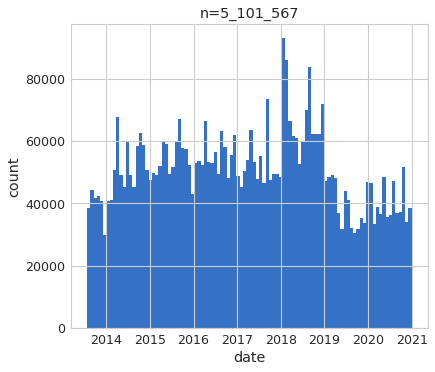

In [17]:
plt.hist(catalog.source_origin_time, bins=100)
plt.xlabel('date')
plt.ylabel('count')
plt.title(f'n={len(catalog.source_origin_time.dropna()):_}')
plt.show()

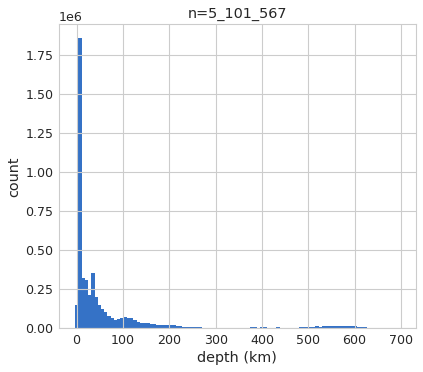

In [19]:
plt.hist(catalog.source_depth_km, bins=100)
plt.xlabel('depth (km)')
plt.ylabel('count')
plt.title(f'n={len(catalog.source_depth_km.dropna()):_}')
plt.show()

In [20]:
catalog.source_magnitude_type.value_counts()

mb       2874385
ML       1051366
Mww       721011
Mwr       277032
Mwb        63654
mb_Lg      61969
Md         33505
Mwc        18404
Ms_20        241
Name: source_magnitude_type, dtype: int64

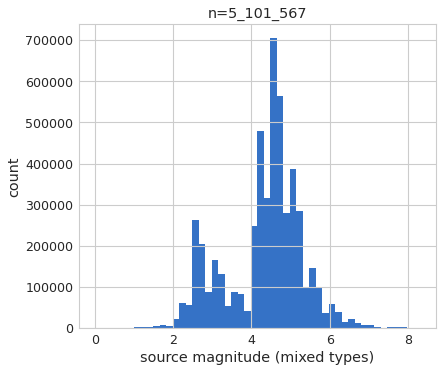

In [21]:
plt.hist(catalog.source_magnitude, bins=50)
plt.xlabel('source magnitude (mixed types)')
plt.ylabel('count')
plt.title(f'n={len(catalog.source_magnitude.dropna()):_}')
plt.show()

In [22]:
catalog.source_magnitude_author.value_counts()[0:20]

us      4229654
ak       330026
tul      232980
hv        37641
ci        23633
pr        19468
slm       19161
guc       18446
gcmt      17636
pgc       14882
nn        14256
nc        13309
ismp       7950
uu         7702
nm         6898
uw         5463
ott        4152
mb         3668
car        3426
ok         2814
Name: source_magnitude_author, dtype: int64

In [23]:
catalog.phase_hint.value_counts()

P     3324809
Pn    1340102
Pg     195496
Sg     152870
Sn      86364
S        1926
Name: phase_hint, dtype: int64

In [24]:
catalog.phase_status.value_counts()

manual       5016351
automatic      85216
Name: phase_status, dtype: int64

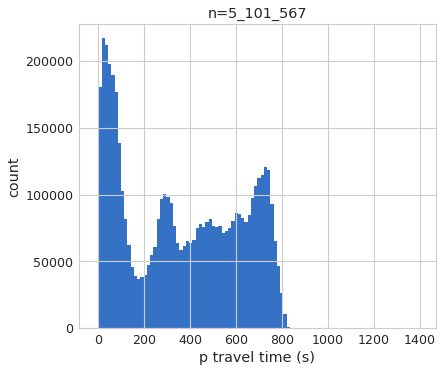

In [25]:
plt.hist(catalog.phase_travel_sec, bins=100)
plt.xlabel('p travel time (s)')
plt.ylabel('count')
plt.title(f'n={len(catalog.phase_travel_sec.dropna()):_}')
plt.show()

In [26]:
#seismic analyst leaderboard
catalog.phase_analyst_id.value_counts()

2990    607837
3230    551304
2971    524981
3482    516693
2989    445150
3222    397621
3187    337119
3395    332337
2932    294054
3429    255380
3341    203974
3653    171228
3029    113942
3231     48076
3190     34934
2171     30503
1469     29140
1466     28053
1461     27051
1464     25683
3439     20809
1623     19839
1650     19002
2964     18394
2173     14737
3388     12549
2543      8612
1596      5183
1569      5067
2974      1193
2161       763
3344       144
2555       106
1515        22
1455        19
3585        19
1542        16
2977        11
1458         9
2183         6
2550         5
3044         1
2535         1
Name: phase_analyst_id, dtype: int64

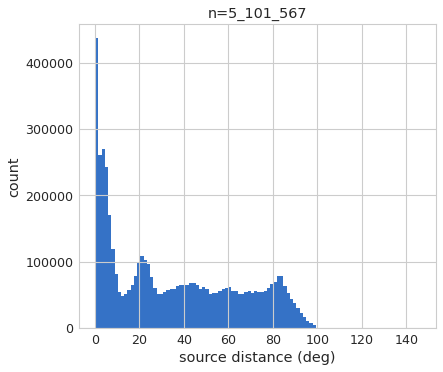

In [27]:
plt.hist(catalog.source_distance_deg, bins=100)
plt.xlabel('source distance (deg)')
plt.ylabel('count')
plt.title(f'n={len(catalog.source_distance_deg.dropna()):_}')
plt.show()

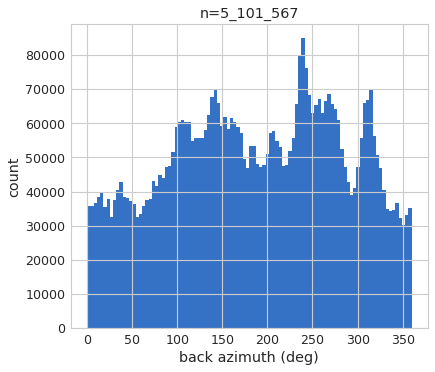

In [30]:
plt.hist(catalog.source_back_azimuth_deg, bins=100)
plt.xlabel('back azimuth (deg)')
plt.ylabel('count')
plt.title(f'n={len(catalog.source_back_azimuth_deg.dropna()):_}')
plt.show()

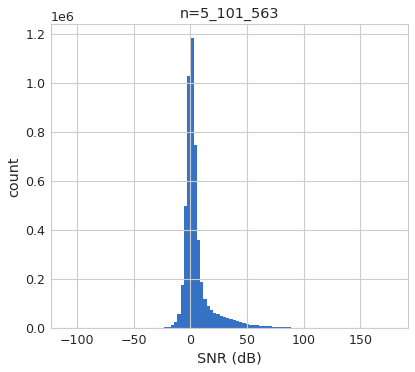

In [31]:
plt.hist(catalog.snr_db, bins=100)
plt.xlabel('SNR (dB)')
plt.ylabel('count')
plt.title(f'n={len(catalog.snr_db.dropna()):_}')
plt.show()